In [147]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from math import factorial


from tqdm import tqdm
import joblib as jl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from IPython.display import Image
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

from src.root_path import config_path
from src.utils.tools import get_quantile_means
from src.visualization.palette import ColorList

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [2]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_20hz'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_chunked'

metrics = ['mass_center', 'last_bin', 'integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC'")
DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220427_probe_firerates'
DF_fr = jl.load(fr_DF_file)

In [3]:
# Calculate delta firing rate
DF_dfr = DF_fr.query("part == 'context'"
                  ).pivot_table(index=['id', 'site', 'chunk', 'probe'], columns=['context'],
                                values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
                     (2 * factorial(DF_dfr.shape[1]-2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx,(c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = np.abs(DF_dfr.values[:,c0] - DF_dfr.values[:,c1])

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())
print(DF_dfr.shape)

             id     site chunk  probe context_pair  delta_fr
0  AMT020a-02-1  AMT020a     A      1        00_01  0.469999
1  AMT020a-02-1  AMT020a     A      2        00_01  0.387749
2  AMT020a-02-1  AMT020a     A      3        00_01  0.469999
3  AMT020a-02-1  AMT020a     A      4        00_01  0.610999
4  AMT020a-02-1  AMT020a     B      1        00_01  0.822499
(1977160, 6)


### regression
how are different delta fr from the context period affect the T value on different parts of the probe period

first for a given neuron

In [ ]:
# simple neuron regression
right = DF_dfr.pivot_table(index=['id', 'site', 'probe', 'context_pair'], columns='chunk', values='delta_fr'
                           ).reset_index()
reg_df = list()
for regressand in ['integral_A', 'integral_B', 'integral_C', 'integral_D']:
    toregress = pd.merge(left=DF.query(f"metric == '{regressand}' and value > 0"),
                          right=right, on=['id', 'site', 'probe', 'context_pair'])

    for neuron in toregress.id.unique():
        neu_df = toregress.query(f"id == '{neuron}'")

        # defines model and fits
        X = neu_df.loc[:,['A', 'B', 'C', 'D']].astype(float)
        X = sm.add_constant(X)
        Y = neu_df['value'].astype(float)
        model = sm.OLS(Y, X, hasconst=True)
        res = model.fit()

        # parses out regression weights i.e. slopes
        try:
            weights = res.params.drop(index='const') # sometime there is no parameters when the regression fails
        except:
            continue
        weights.name='weigths'
        CI = res.conf_int().drop(index='const').rename(columns={0:'lower_ci',1:'upper_ci'})

        # compiles in a df with extra info about results source
        d = pd.concat([weights, CI], axis=1)
        d['id'] = neuron
        d['regresor'] = 'self'
        d['regressand'] = regressand

        reg_df.append(d)

reg_df = pd.concat(reg_df)

  chunk     weigths   lower_ci    upper_ci            id regresor  regressand
0     A  -87.158131        NaN         NaN  ARM033a-51-3     self  integral_A
1     B  -87.060897        NaN         NaN  ARM033a-51-3     self  integral_A
2     C   56.355451        NaN         NaN  ARM033a-51-3     self  integral_A
3     D   94.863377        NaN         NaN  ARM033a-51-3     self  integral_A
4     A  259.058681  66.168394  451.948968  ARM033a-06-1     self  integral_A


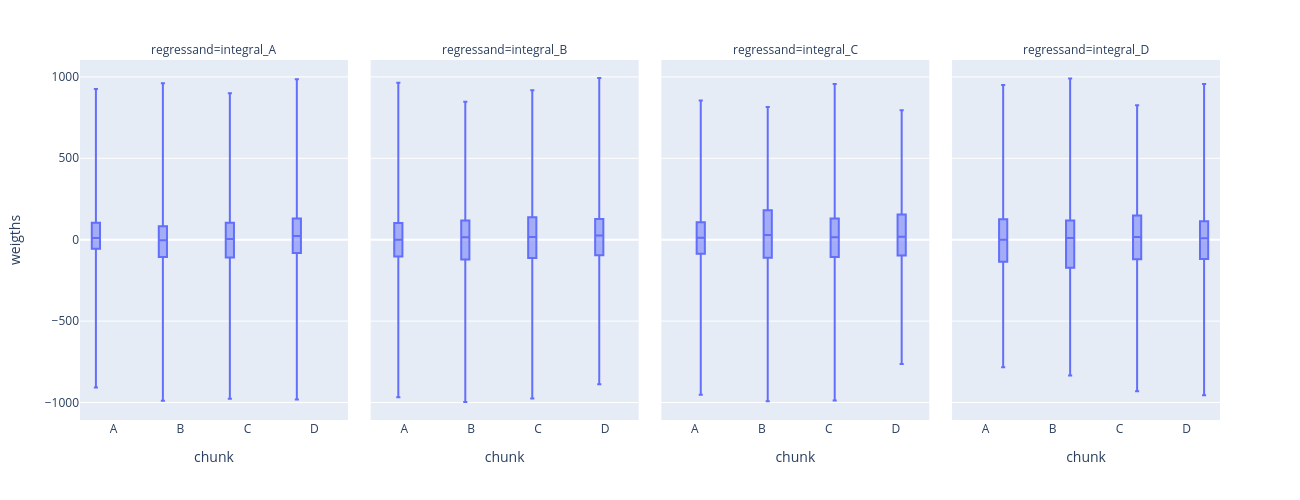

In [5]:
toplot = reg_df.reset_index().rename(columns={'index':'chunk'}).query('weigths < 1000 and weigths >-1000')
print(toplot.head())

fig = px.box(toplot.reset_index(), x='chunk', y='weigths', points=False, facet_col='regressand')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=500)
Image(img_bytes)

### recreate old results

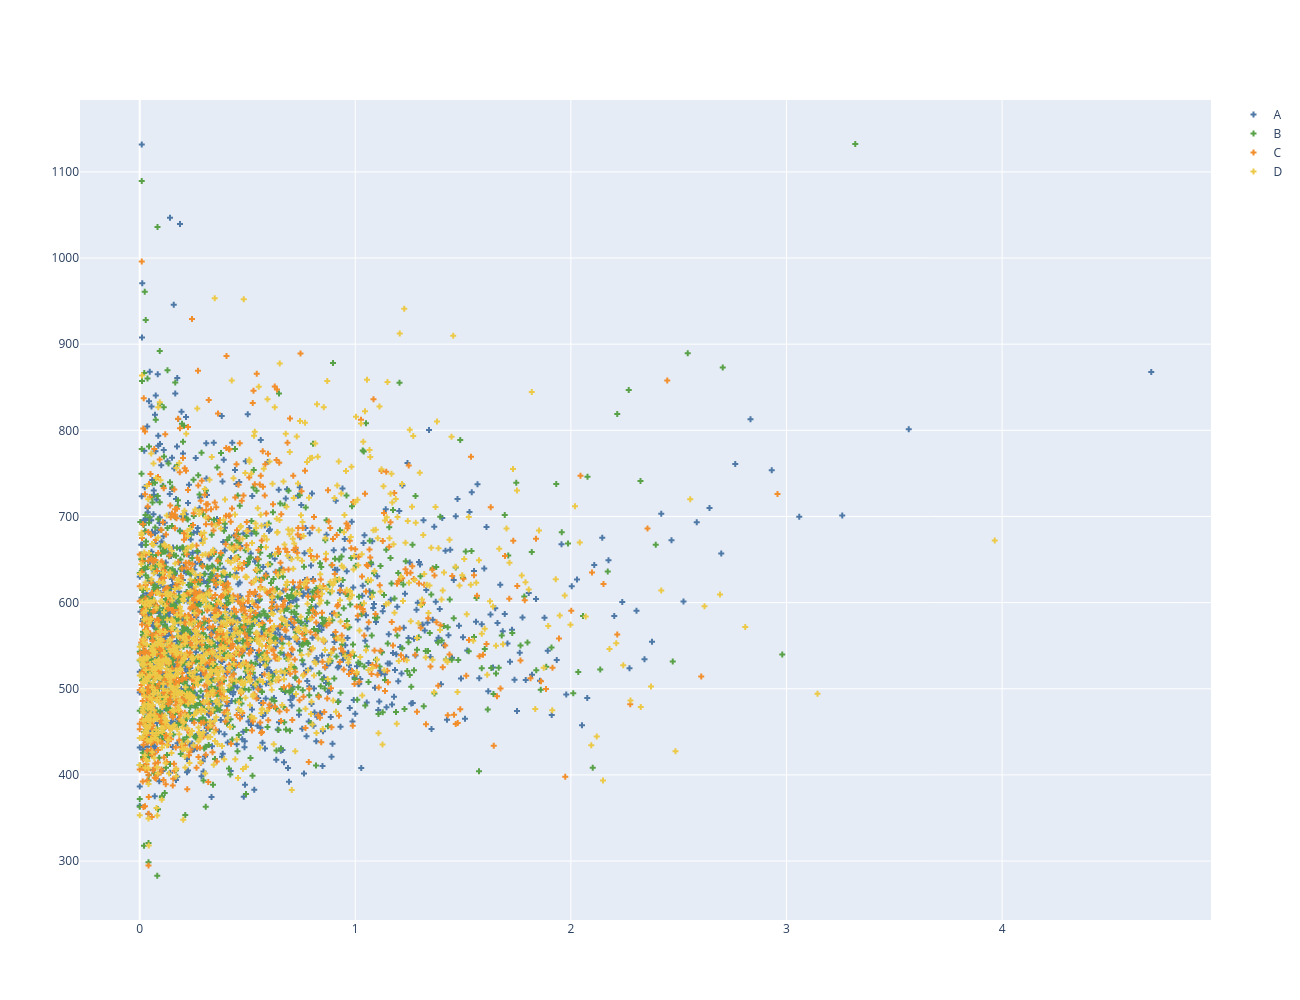

In [6]:
# Y is the center of mass, or better the last bin. X is the delta firing rate at different times
right = DF_dfr.pivot_table(index=['id', 'site', 'probe', 'context_pair'], columns='chunk', values='delta_fr'
                           ).reset_index()
# right = DF_dfr
left = DF.query("metric == 'integral' and value >0")
toregress = pd.merge(left, right, on=['id', 'context_pair', 'probe'])

# fig = make_subplots(1, 4)
fig = go.Figure()
for cc, chunk in enumerate(['A','B','C','D']):
    # scatter
    # rndsmp = np.random.random_sample(size=x.shape) < 0.2 # subsamples 20% of the data
    color = ColorList[cc%len(ColorList)]

    # fig.add_trace(go.Scattergl(x=toregress['A'], y=toregress['value'], mode='markers',
    #                            opacity=0.3,
    #                            marker=dict(opacity=0.5,
    #                                        size=3,
    #                                        color=color,
    #                                        line_color='black'),
    #                            showlegend=False,
    #                            hoverinfo='skip'))

    # trendline
    xm, ym = get_quantile_means(x=toregress[chunk], y=toregress['value'], n_quantiles=1000)
    fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                             marker=dict(opacity=1,
                                         color=color,
                                         symbol='cross',
                                         size=5),
                             line_width=2,
                             name=chunk,
                             showlegend=True))


img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

# Regress delta fr to itself!

In [129]:
# Calculate delta firing rate
DF_dfr = DF_fr.query("context != 'mean'"
                  ).pivot_table(index=['part', 'id', 'site', 'chunk', 'probe'], columns=['context'],
                                values='value', aggfunc='first')

n_comb = int(factorial(DF_dfr.shape[1]) /
                     (2 * factorial(DF_dfr.shape[1]-2)))
ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx,(c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = DF_dfr.values[:,c0] - DF_dfr.values[:,c1]

DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
print(DF_dfr.head())

      part            id     site chunk  probe context_pair  delta_fr
0  context  AMT020a-02-1  AMT020a     A      1        00_01 -0.469999
1  context  AMT020a-02-1  AMT020a     A      2        00_01 -0.387749
2  context  AMT020a-02-1  AMT020a     A      3        00_01 -0.469999
3  context  AMT020a-02-1  AMT020a     A      4        00_01 -0.610999
4  context  AMT020a-02-1  AMT020a     B      1        00_01 -0.822499


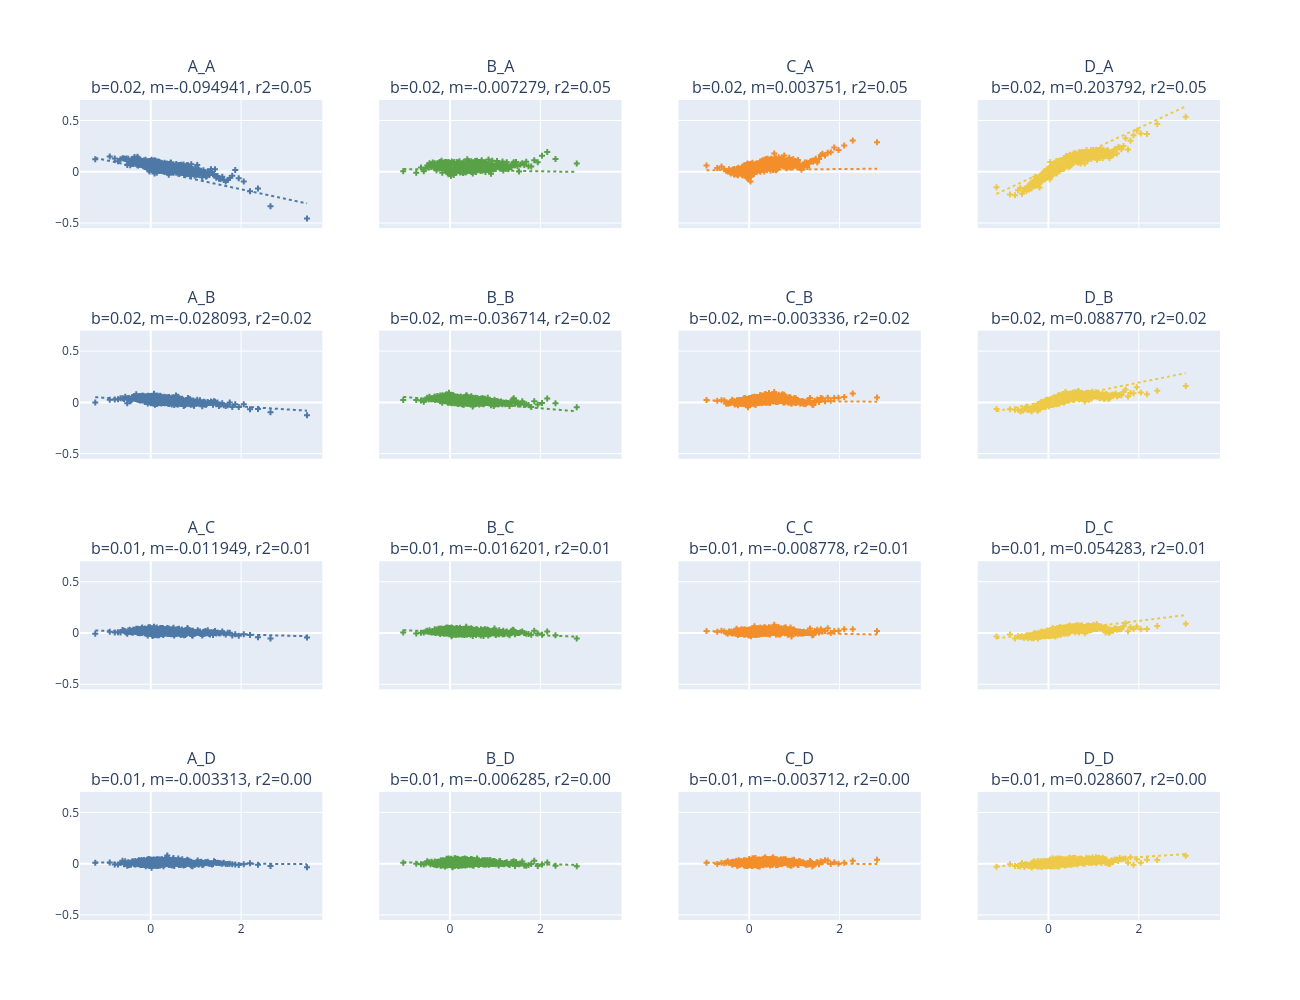

In [77]:
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

left = DF_dfr.query("part == 'context'")
res_dict = dict()
subtitles = dict()
for pc, prb_chunk in enumerate(['A','B','C','D']):
    right = DF_dfr.query(f"part == 'probe' and chunk == '{prb_chunk}'")

    toregress = pd.merge(left, right, on=['id', 'probe', 'context_pair'], validate="m:1"
                         ).pivot_table(index=['id', 'context_pair', 'probe', 'delta_fr_y'],
                                       columns=['chunk_x'],
                                       values='delta_fr_x', aggfunc='first').reset_index().copy()

    # flips values to enforce positive x since its an arbitrary sing.
    # alax x are related, and they might have opposite signs, takes  the mean across them

    # flipper = (toregress['delta_fr_y'] >= 0) * 2 -1
    # flipper = (toregress.loc[:,'D'] >= 0) * 2 -1
    flipper = (toregress.loc[:,['A', 'B', 'C', 'D']].values.mean(axis=1) >= 0) * 2 -1
    toregress.loc[:,['delta_fr_y','A', 'B', 'C', 'D']] = toregress.loc[:,['delta_fr_y','A', 'B', 'C', 'D']
                                                         ].values * flipper[:,None]


    # run regression
    X = toregress.loc[:,['A', 'B', 'C', 'D']].astype(float)
    X = sm.add_constant(X)
    Y = toregress['delta_fr_y'].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res


    for cc, ctx_chunk in enumerate(['A','B','C','D']):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress['delta_fr_y'].values

        # decimated scatterplot
        xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 name=chunk,
                                 showlegend=False), row=pc+1, col=cc+1)

        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]

        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        name = f"{ctx_chunk}_{prb_chunk}<br>" \
               f"b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[f'{ctx_chunk}_{prb_chunk}'] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

In [81]:
print(res_dict['A'].summary())

                            OLS Regression Results                            
Dep. Variable:             delta_fr_y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     6629.
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        15:24:02   Log-Likelihood:            -2.1181e+05
No. Observations:              494290   AIC:                         4.236e+05
Df Residuals:                  494285   BIC:                         4.237e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0187      0.001     25.835      0.0

## firing rate regression for individual neurons
plot example neuron

In [137]:
def  get_site_neu_reg_df(cellid, dim_red):
    # dimensionality reduction, multiple alternatives.
    # rregressors: all other neurons in the site
    try:
        del(x); del(y)
    except:
        pass
    if dim_red == 'pca_fr':

        X = DF_fr.query(f"part == 'context' and  site == '{cellid.split('-')[0]}' and id != '{cellid}'"
                        ).pivot_table(index=['chunk', 'probe', 'context'], columns=['id'],
                                      values='value', aggfunc='first')
        PC1 = PCA(n_components=1).fit_transform(X.values)
        X = pd.Series(index=X.index, data=PC1[:, 0]
                      ).reset_index().pivot_table(index=['chunk', 'probe'], columns='context', values=0,
                                                  aggfunc='first')

        # Calculate delta firing rate
        n_comb = int(factorial(X.shape[1]) /
                     (2 * factorial(X.shape[1] - 2)))
        ctx_pair_R = np.full((X.shape[0], n_comb), np.nan)
        new_cols = list()
        for pr_idx, (c0, c1) in enumerate(itt.combinations(X.columns, r=2)):
            new_cols.append(f'{c0:02}_{c1:02}')
            ctx_pair_R[:, pr_idx] = X.values[:, c0] - X.values[:, c1]

        X = pd.DataFrame(index=X.index, columns=new_cols, data=ctx_pair_R
                         ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()

        X = X.pivot_table(index=['probe', 'context_pair'], columns='chunk', values='delta_fr',
                          aggfunc='first').reset_index()

    elif dim_red in ['abs_mean_dfr', 'pca_dfr']:
        X = DF_dfr.query(f"site == '{cellid.split('-')[0]}' and id != '{cellid}' and part == 'context'")
        X = X.pivot_table(index=['id'], columns=['context_pair', 'probe', 'chunk'], values='delta_fr', aggfunc='first')

        if dim_red == 'abs_mean_dfr':
            # Take mean of aboslute value
            X = X.apply(lambda x: np.mean(np.absolute(x)), axis=0).reset_index()
        elif dim_red == 'pca_dfr':
            # pca of delta firing rates
            Xt = PCA(n_components=1).fit_transform(X=X.values.T)
            X = pd.Series(index=X.columns, data=Xt[:, 0]).reset_index()
        else:
            assert False

        X = X.pivot_table(index=['context_pair', 'probe'], columns='chunk', values=0).reset_index()
    else:
        assert False

    # regressand: the selected neuron at the selected time point
    Y = DF_dfr.query(f"id == '{cellid}' and part == 'probe'")
    Y = Y.pivot_table(index=['context_pair', 'probe'], columns='chunk', values='delta_fr', aggfunc='first'
                      ).reset_index()

    toregress = pd.merge(X, Y, on=['context_pair', 'probe'], validate='1:1')

    return toregress

### pca_fr vs pca_dfr
seems like the results from  pca over the raw firing rate or the paired firing rate difference are
justiffied in their similarity

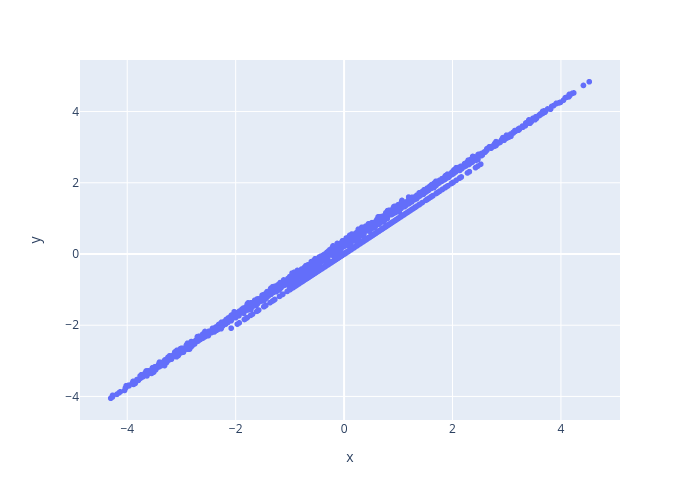

In [146]:
aaa = get_site_neu_reg_df('TNC014a-22-2', 'pca_fr')
bbb = get_site_neu_reg_df('TNC014a-22-2', 'pca_dfr')

mmm = pd.merge(aaa ,bbb, on=['context_pair','probe'])
aaa = mmm.loc[:, [col for col in mmm.columns if col[-1] == 'x']].values.flatten()
bbb = mmm.loc[:, [col for col in mmm.columns if col[-1] == 'y']].values.flatten()
fig = px.scatter(x=aaa, y=bbb)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

plain fr


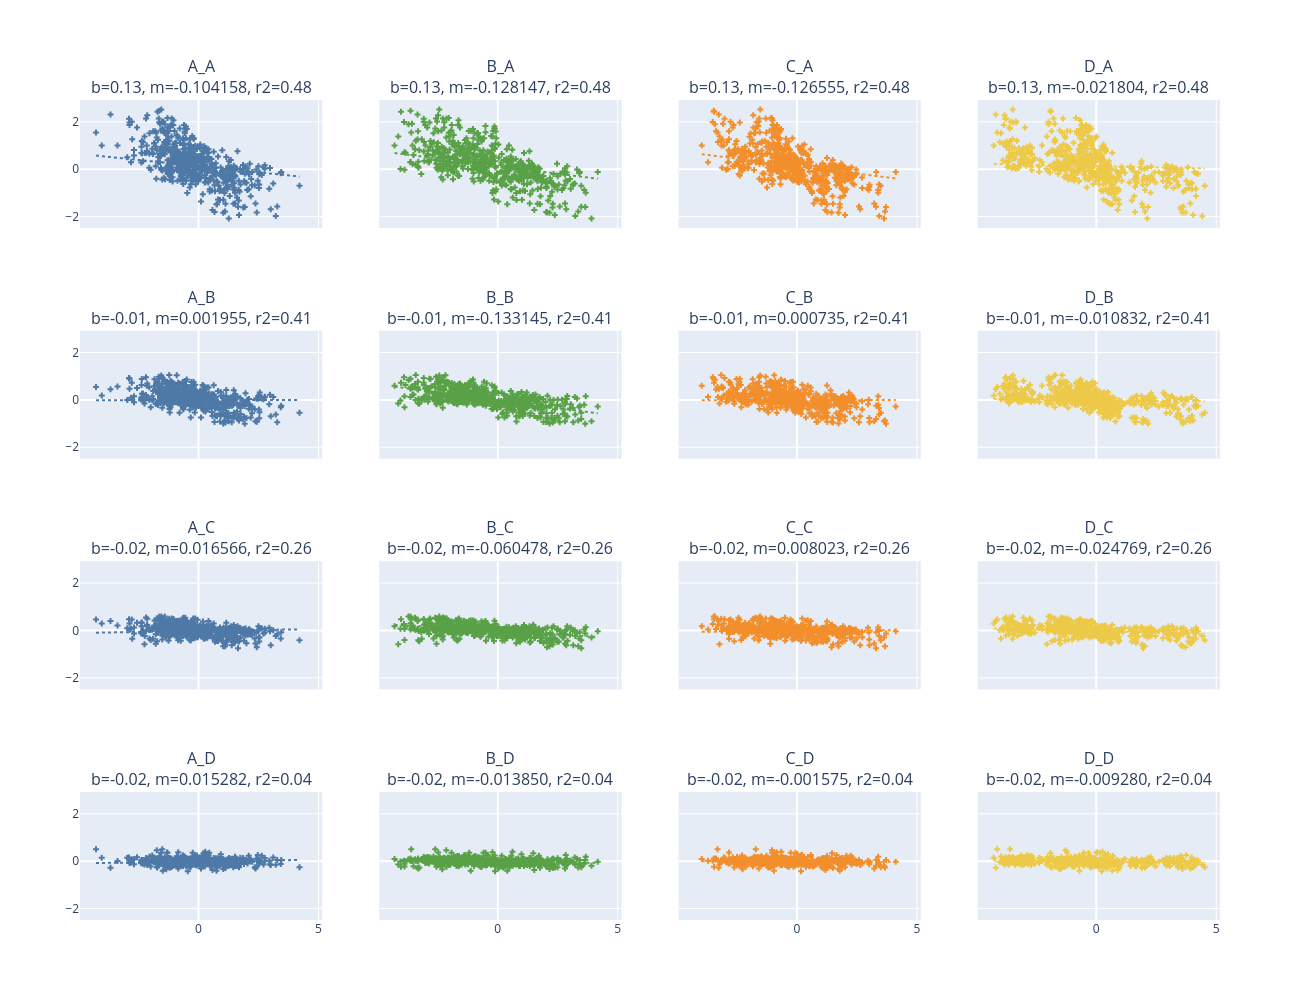

In [131]:
toregress = get_site_neu_reg_df('TNC014a-22-2', 'pca_fr')

res_dict = dict() # todo, what is important to keep??
subtitles = dict()
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

for pc, prb_chunk in enumerate([ss for ss in toregress.columns if '_y' in ss]):
    # run regression
    X = toregress.loc[:,['A_x', 'B_x', 'C_x', 'D_x']].astype(float)
    X = sm.add_constant(X)
    Y = toregress[prb_chunk].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res

    for cc, ctx_chunk in enumerate([ss for ss in toregress.columns if '_x' in ss]):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress[prb_chunk].values

        # decimated scatterplot
        # xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        xm, ym = x, y
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 name=chunk,
                                 showlegend=False), row=pc+1, col=cc+1)

        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]

        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        locstr = f"{ctx_chunk.split('_')[0]}_{prb_chunk.split('_')[0]}"
        name = f"{locstr}<br>b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[locstr] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

### sanity check that the slicing and regressions work
notice the differnce in regression lines: in top figure rows are fitted together and share a bias and r2,
for the bottom figure each line/pannel is fitted independently

In [148]:
toregress = get_site_neu_reg_df('TNC014a-22-2', 'pca_fr')
melting = toregress.melt(id_vars=['context_pair', 'probe', 'A_y', 'B_y', 'C_y', 'D_y'],
                         value_vars=['A_x', 'B_x', 'C_x', 'D_x'],
                         value_name='value_x').rename(columns={'chunk': 'context_chunk'})
melting = melting.melt(id_vars=['context_pair', 'probe', 'context_chunk', 'value_x'],
                         value_vars=['A_y', 'B_y', 'C_y', 'D_y'],
                         value_name='value_y').rename(columns={'variable': 'probe_chunk'})
fig = px.scatter(melting, x='value_x', y ='value_y', facet_col='context_chunk', facet_row='probe_chunk',
                 trendline='ols')

fig.show()

### get the regression df parameters for all neurons D:

In [167]:
recacheDF = False
full_reg_df_file = pl.Path(config['paths']['analysis_cache']) / f'220428_pop_to_neu_dfr_reg'
full_reg_df_file.parent.mkdir(parents=True, exist_ok=True)
if full_reg_df_file.exists() and not recacheDF:
    full_toregress = jl.load(full_reg_df_file)
else:
    full_toregress = list()
    for cellid in tqdm(DF_dfr.id.unique()):
        d = get_site_neu_reg_df(cellid, 'pca_fr')
        d['id'] = cellid
        full_toregress.append(d)

    full_toregress = pd.concat(full_toregress, ignore_index=True)
    jl.dump(full_toregress, full_reg_df_file)


100%|██████████| 1709/1709 [06:57<00:00,  4.09it/s]


In [168]:
# filters instances for real significance
idx_filt = DF.query("metric == 'integral' and value > 0").drop(columns=['value','metric'])
toregress = pd.merge(full_toregress, idx_filt, on=['id', 'context_pair', 'probe'])
toregress

,probe,context_pair,A_x,B_x,C_x,D_x,A_y,B_y,C_y,D_y,id,site,region,stim_count
0,2,00_02,-1.578213,-0.274677,-0.615943,-1.664506,0.340750,0.082250,0.105750,0.035250,AMT020a-02-1,AMT020a,A1,4
1,3,01_02,1.611875,2.863737,2.937237,1.705308,0.724521,0.362260,0.226413,0.120753,AMT020a-08-1,AMT020a,A1,4
2,3,02_04,-0.862932,-2.402587,-1.697471,-0.476082,-0.498108,-0.060377,-0.135848,0.030188,AMT020a-08-1,AMT020a,A1,4
3,3,03_04,-0.778458,-2.668829,-2.401469,-0.780656,-0.513202,0.045283,-0.045283,0.075471,AMT020a-08-1,AMT020a,A1,4
4,4,01_02,2.678148,3.285358,3.414136,2.035023,1.116969,0.483014,0.166036,-0.588673,AMT020a-08-1,AMT020a,A1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40190,4,01_04,0.543860,-0.181911,0.021451,-0.862425,-0.064956,0.173217,0.043304,-0.194869,ley072b-34-1,ley072b,A1,4
40191,4,02_04,1.516880,1.125471,0.582724,0.095147,-0.075783,0.119087,-0.313956,-0.119087,ley072b-34-1,ley072b,A1,4
40192,4,02_03,0.038915,-0.381989,-1.205087,-0.512632,0.025245,0.138845,0.063111,0.353424,ley075b-12-1,ley075b,A1,4
40193,3,02_04,0.174843,0.221489,-0.744222,-0.957521,-0.573267,-0.440974,-0.361599,-0.326321,ley075b-17-1,ley075b,A1,4


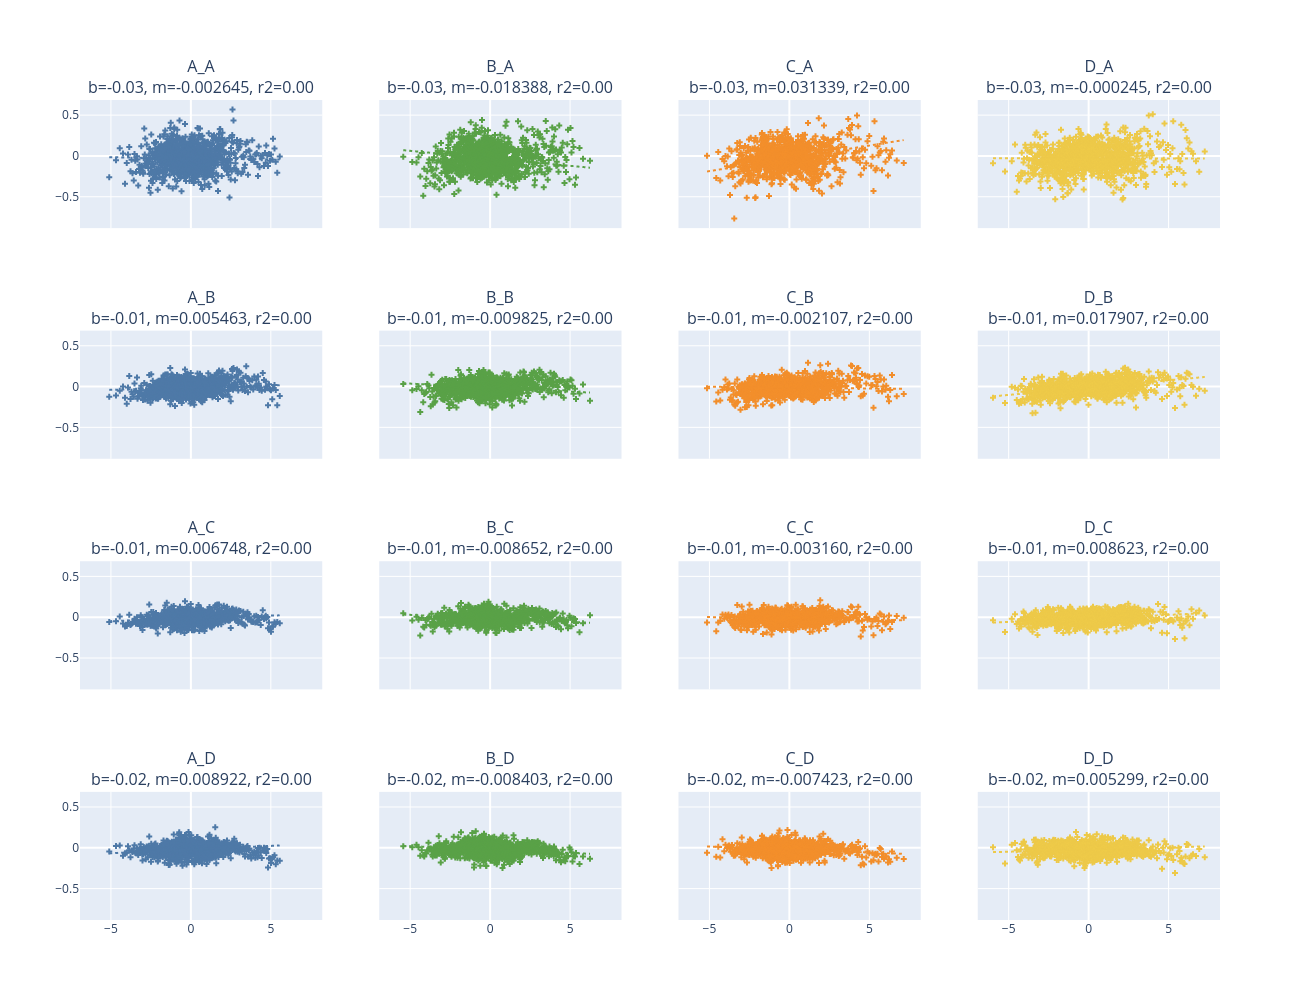

In [169]:
res_dict = dict() # todo, what is important to keep??
subtitles = dict()
fig = make_subplots(4, 4, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles=[f"{CC}_{PC}" for PC, CC in itt.product(['A','B','C','D'], repeat=2)])

for pc, prb_chunk in enumerate([ss for ss in toregress.columns if '_y' in ss]):
    # run regression
    X = toregress.loc[:,['A_x', 'B_x', 'C_x', 'D_x']].astype(float)
    X = sm.add_constant(X)
    Y = toregress[prb_chunk].astype(float)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    res_dict[prb_chunk] = res

    for cc, ctx_chunk in enumerate([ss for ss in toregress.columns if '_x' in ss]):

        color = ColorList[cc%len(ColorList)]

        x = toregress[ctx_chunk].values
        y = toregress[prb_chunk].values

        # decimated scatterplot
        xm, ym = get_quantile_means(x=x, y=y, n_quantiles=1000)
        # xm, ym = x, y
        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(opacity=1,
                                             color=color,
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 name=chunk,
                                 showlegend=False), row=pc+1, col=cc+1)

        xr = np.asarray([np.nanmin(xm), np.nanmax(xm)]).squeeze().astype(float)
        yr = res.params['const'] + xr * res.params[ctx_chunk]

        fig.add_trace(go.Scatter(x=xr, y=yr, mode='lines',
                                 line=dict(width=2,
                                           color=color,
                                           dash='dot'),
                                 showlegend=False), row=pc+1, col=cc+1)


        # saves subplot title
        locstr = f"{ctx_chunk.split('_')[0]}_{prb_chunk.split('_')[0]}"
        name = f"{locstr}<br>b={res.params['const']:.2f}, m={res.params[ctx_chunk]:2f}, r2={res.rsquared:.2f}"
        subtitles[locstr] = name

fig.update_layout(showlegend=False)
# names = {'Plot 1':'2016', 'Plot 2':'2017', 'Plot 3':'2018', 'Plot 4':'2019'}
fig.for_each_annotation(lambda a: a.update(text = subtitles[a.text]))

# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)